# Create split folders

In [3]:
import os
import re
import shutil
SETS = ['training', 'validation', 'tests']
FEATURES = ['dwt', 'dtcwt']
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
for set in SETS:
    os.mkdir(f'./dataset/split/{set}')
    os.mkdir(f'./dataset/split/{set}/data')
    os.mkdir(f'./dataset/split/{set}/features')
    
    for feat in FEATURES:
        os.mkdir(f'./dataset/split/{set}/features/{feat}')

        for genre in GENRES:
            if genre not in os.listdir(f'./dataset/split/{set}/data'):
                os.mkdir(f'./dataset/split/{set}/data/{genre}')
            os.mkdir(f'./dataset/split/{set}/features/{feat}/{genre}')  

## Move files to the split folders and delete unnecesary files

In [18]:
# remove all unnecesary files
for genre in GENRES:
    for wav in os.listdir(f'dataset/genres/{genre}'):
        matched = re.match(r"(\w+).(\d+).wav", wav)
        if matched:
            _, i = matched.groups()
            i = int(i)
            dest = ''

            if i >=0 and i <= 79:
                dest = f'dataset/split/training/data/{genre}'
            elif i >= 80 and i <= 89:
                dest = f'dataset/split/validation/data/{genre}'
            else:
                dest = f'dataset/split/tests/data/{genre}'

            shutil.copy2(
                src=f'dataset/genres/{genre}/{wav}',
                dst=dest
            )

shutil.rmtree('dataset/genres')

## Extract wavelet features for each file and place them in the corresponding folders

### Discrete Wavelet Transform (DWT) 

In [46]:
import numpy as np
import pywt
from collections import Counter
import scipy
import librosa

wavelet_name = 'db12' # TODO try db20

In [47]:
def calculate_entropy(list_values):
	counter_values = Counter(list_values).most_common()
	probabilities = [elem[1]/len(list_values) for elem in counter_values]
	entropy=scipy.stats.entropy(probabilities)
	return entropy

def calculate_statistics(list_values):
	n5 = np.nanpercentile(list_values, 5)
	n25 = np.nanpercentile(list_values, 25)
	n75 = np.nanpercentile(list_values, 75)
	n95 = np.nanpercentile(list_values, 95)
	median = np.nanpercentile(list_values, 50)
	mean = np.nanmean(list_values)
	std = np.nanstd(list_values)
	var = np.nanvar(list_values)
	rms = np.nanmean(np.sqrt(list_values**2))
	return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
	zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
	no_zero_crossings = len(zero_crossing_indices)
	mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
	no_mean_crossings = len(mean_crossing_indices)
	return [no_zero_crossings, no_mean_crossings]
    
def get_features(list_values):
	entropy = calculate_entropy(list_values)
	crossings = calculate_crossings(list_values)
	statistics = calculate_statistics(list_values)
	return [entropy] + crossings + statistics

In [48]:
def extract_dwt(file_path:str):
    d, fs = librosa.load(file_path)
    list_coeff = pywt.wavedec(d, wavelet_name)
    features = []
    for coeff in list_coeff:
        features += get_features(coeff)
    return features


In [123]:
full_x_featuresDict = {set:[] for set in SETS}
y = {set:[] for set in SETS}
full_x_features = []

# extract features from the data set

for genre in GENRES:    
    for set in SETS:
        for wav in os.listdir(f'dataset/split/{set}/data/{genre}'):
            if wav == 'jazz.00054.wav': continue
            file_path = f'dataset/split/{set}/data/{genre}/{wav}'
            name = wav.removesuffix('.wav')
            destination = f'dataset/split/{set}/features/dwt/{genre}/{name}'
            try: 
                with open(destination+'.npy' ,'rb'):
                    continue
            except:
                features = extract_dwt(file_path)
                full_x_featuresDict[set].append(features)
                y[set].append(genre)
                full_x_features.append(features)
                features_array = np.array(features)
                np.save(destination, features_array)


In [124]:
full_x_features = np.array(full_x_features)
np.save('dataset/fullXfeat_dwt', full_x_features)

## Load DWT features and do some parameters tuning on Random Forest and Gradient Boosting

In [55]:
full_x_features = np.load('dataset/fullXfeat_dwt.npy')
full_x_features.shape

(999, 180)

In [57]:
full_y  = [] 
y = {set:[] for set in SETS}
for genre in GENRES:
    for set in SETS:    
        for wav in os.listdir(f'dataset/split/{set}/data/{genre}'):
            if wav == 'jazz.00054.wav': continue
            y[set].append(genre)
            full_y.append(genre)

y_training = y['training']
y_validation = y['validation']
y_tests = y['tests']
print(len(y_training),len(y_validation),len(y_tests),len(full_y))

799 100 100 999


In [62]:
# get the features matrix for each set
def load_matrix_for_set(set:str):
    data = []
    for genre in GENRES:
        for s_feat in os.listdir(f'dataset/split/{set}/features/dwt/{genre}'):
            feat = np.load(f'dataset/split/{set}/features/dwt/{genre}/{s_feat}')
            data.append(feat)
    X_data_array = np.array(data)
    np.save(f'dataset/split/{set}/features/dwt/X_dwt_matrix_db12', X_data_array)


try:
    X_array_training = np.load(f'dataset/split/training/features/dwt/X_dwt_matrix_db12.npy')
except: 
    load_matrix_for_set('training')
    X_array_training = np.load(f'dataset/split/training/features/dwt/X_dwt_matrix_db12.npy')

try:
    X_array_dwt_valid = np.load(f'dataset/split/validation/features/dwt/X_dwt_matrix_db12.npy')
except: 
    load_matrix_for_set('validation')
    X_array_dwt_valid = np.load(f'dataset/split/validation/features/dwt/X_dwt_matrix_db12.npy')

try:
    X_array_dwt_test = np.load(f'dataset/split/tests/features/dwt/X_dwt_matrix_db12.npy')
except: 
    load_matrix_for_set('tests')
    X_array_dwt_test = np.load(f'dataset/split/tests/features/dwt/X_dwt_matrix_db12.npy')


In [101]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
# transform class labels, from genres string to integers from 0 to 9.
# y_training = encoder.fit_transform(y['training']) 
# y_validation = encoder.fit_transform(np.concatenate((y['validation'], y['tests']), axis=0))

full_y = encoder.fit_transform(full_y)

scaler = StandardScaler()
# X_dwt_train = scaler.fit_transform(X_array_training)
# X_dwt_valid = scaler.fit_transform(np.concatenate((X_array_dwt_valid, X_array_dwt_test), axis=0))
# X_dwt_train.shape,X_dwt_valid.shape,y_training.shape,y_validation.shape

full_x_features = scaler.fit_transform(full_x_features)
X_dwt_train_f, X_dwt_test_f, y_dwt_train_f, y_dwt_test_f = train_test_split(full_x_features, full_y, test_size = 0.2,random_state=42)

Random Forest best found parameters were: `n_estimators=100, max_depth=13, bootstrap=False`

In [111]:
from sklearn.ensemble import RandomForestClassifier

rf_cls = RandomForestClassifier(n_estimators=100,max_depth=13,bootstrap=False,random_state=42)

rf_cls.fit(X_dwt_train_f,y_dwt_train_f)
# 1.2 sec
print(rf_cls.score(X_dwt_train_f,y_dwt_train_f))
# 1.0
print(rf_cls.score(X_dwt_test_f, y_dwt_test_f))
# 0.78
ypred_dwt_rf = rf_cls.predict(X_dwt_test_f)

1.0
0.78


Plot a confusion matrix to corroborate the behavior of the model for each genre

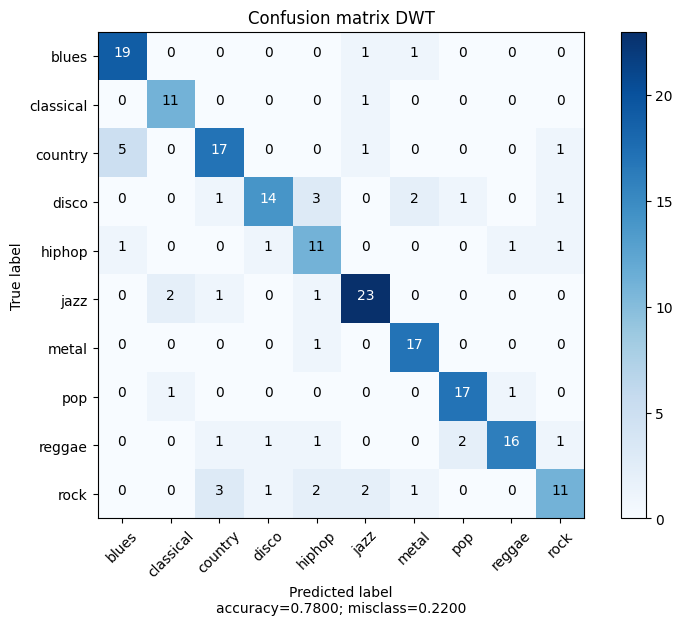

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_dwt_test_f, ypred_dwt_rf)

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix DWT Random Forest')
plt.colorbar()

tick_marks = np.arange(len(GENRES))
plt.xticks(tick_marks, GENRES, rotation=45)
plt.yticks(tick_marks, GENRES)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > (cm.max() / 2) else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('ConfM_DWT_rf.png')

A Cross-Validation using K-Fold to validate the accuracy in the previous fit

scores:  [0.715      0.71       0.8        0.76       0.76884422]
mean:  0.7507688442211055


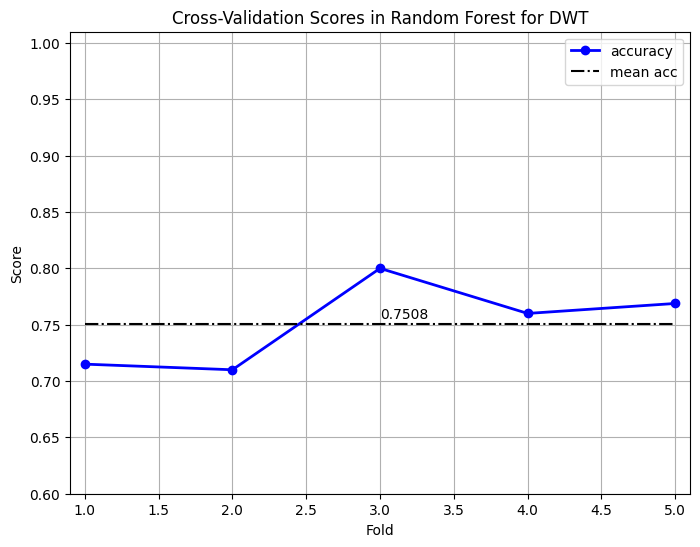

In [107]:
from sklearn.model_selection import KFold, cross_val_score
kfold=KFold(n_splits=5 , shuffle=True,random_state=0) 
rf_scores = cross_val_score(rf_cls,full_x_features, full_y,cv=kfold)

print('scores: ',rf_scores) # [0.715      0.71       0.8        0.76       0.76884422]
print('mean: ',rf_scores.mean()) # 0.7507688442211055

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Cross-Validation Scores in Random Forest for DWT')
plt.xlabel('Fold')
plt.ylabel('Score')
ax = plt.gca()
ax.set_xlim(0.9, 5.1)
ax.set_ylim(0.6, 1.01)
plt.grid()
plt.plot(range(1,6),rf_scores,'o-',color='blue',lw=2)
plt.plot(range(1,6),[rf_scores.mean()]*5, linestyle="-.",color='k')
plt.annotate("%0.4f" % rf_scores.mean(), (3,rf_scores.mean() + 0.005))
plt.legend(['accuracy','mean acc'],loc="best")
plt.savefig('CV_DWT_rf.png')

Gradient Boosting best found parameters were: `n_estimators=1000`

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

gb_cls = GradientBoostingClassifier(n_estimators=1000,random_state=0)

gb_cls.fit(X_dwt_train_f,y_dwt_train_f)
# 6 min 34 sec
print(gb_cls.score(X_dwt_train_f,y_dwt_train_f))
# 1.0
print(gb_cls.score(X_dwt_test_f, y_dwt_test_f))
# 0.74
ypred_dwt_gb = gb_cls.predict(X_dwt_test_f)

Plot a confusion matrix to corroborate the behavior of the model for each genre

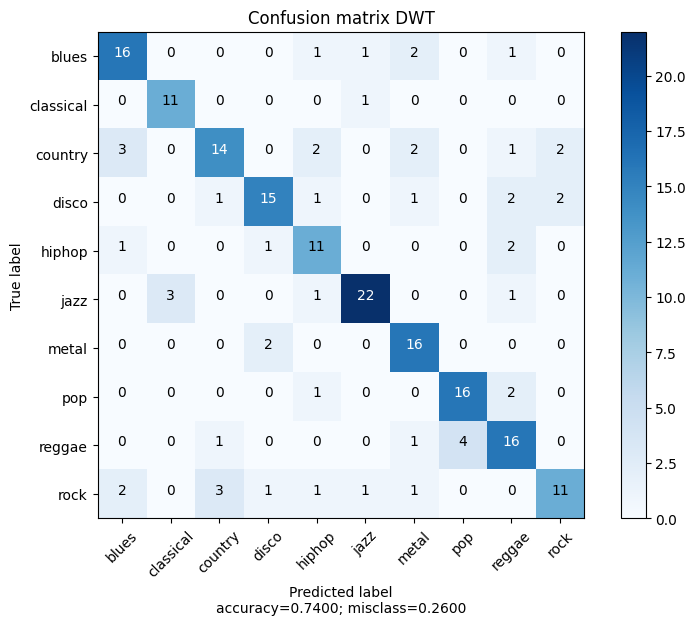

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_dwt_test_f, ypred_dwt_gb)

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix DWT Gradient Boosting')
plt.colorbar()

tick_marks = np.arange(len(GENRES))
plt.xticks(tick_marks, GENRES, rotation=45)
plt.yticks(tick_marks, GENRES)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > (cm.max() / 2) else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('ConfM_DWT_gb.png')

A Cross-Validation using K-Fold to validate the accuracy in the previous fit

scores:  [0.735      0.7        0.755      0.765      0.75879397]
mean:  0.7427587939698492


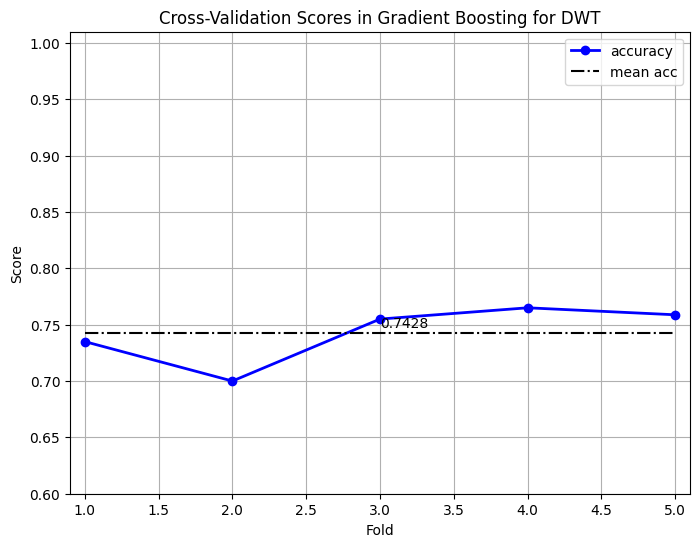

In [115]:
from sklearn.model_selection import KFold, cross_val_score
kfold=KFold(n_splits=5 , shuffle=True,random_state=0) 
gb_scores = cross_val_score(gb_cls,full_x_features, full_y,cv=kfold)

print('scores: ',gb_scores) # [0.715      0.71       0.8        0.76       0.76884422]
print('mean: ',gb_scores.mean()) # 0.7507688442211055

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Cross-Validation Scores in Gradient Boosting for DWT')
plt.xlabel('Fold')
plt.ylabel('Score')
ax = plt.gca()
ax.set_xlim(0.9, 5.1)
ax.set_ylim(0.6, 1.01)
plt.grid()
plt.plot(range(1,6),gb_scores,'o-',color='blue',lw=2)
plt.plot(range(1,6),[gb_scores.mean()]*5, linestyle="-.",color='k')
plt.annotate("%0.4f" % gb_scores.mean(), (3,gb_scores.mean() + 0.005))
plt.legend(['accuracy','mean acc'],loc="best")
plt.savefig('CV_DWT_gb.png')

### Dual-Tree Complex Wavelet Transform (DTCWT)

In [116]:
import librosa
import numpy as np
from collections import Counter
import scipy
import dtcwt

trans = dtcwt.Transform1d(biort='antonini', qshift='qshift_d')

In [117]:
def calculate_entropy(list_values):
	counter_values = Counter(list_values).most_common()
	probabilities = [elem[1]/len(list_values) for elem in counter_values]
	entropy=scipy.stats.entropy(probabilities)
	return entropy

def calculate_statistics(list_values):
	n5 = np.nanpercentile(list_values, 5)
	n25 = np.nanpercentile(list_values, 25)
	n75 = np.nanpercentile(list_values, 75)
	n95 = np.nanpercentile(list_values, 95)
	median = np.nanpercentile(list_values, 50)
	mean = np.nanmean(list_values)
	std = np.nanstd(list_values)
	var = np.nanvar(list_values)
	rms = np.nanmean(np.sqrt(list_values**2))
	return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
	zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
	no_zero_crossings = len(zero_crossing_indices)
	mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
	no_mean_crossings = len(mean_crossing_indices)
	return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
	entropy = calculate_entropy(list_values)
	crossings = calculate_crossings(list_values)
	statistics = calculate_statistics(list_values)
	return [entropy] + crossings + statistics

In [118]:
def extract_dtcwt(file_path:str):    
    d, fs = librosa.load(file_path)
    forw = trans.forward(d, nlevels=17)
    features = []
    for coeff in forw.highpasses:
        temp = (np.abs(coeff.squeeze()))
        features += get_features(temp)
        
    features += get_features(forw.lowpass.squeeze())    
    return features


In [125]:
full_x_featuresDict = {set:[] for set in SETS}
y = {set:[] for set in SETS}
full_x_features = []

# extract features from the data set

for genre in GENRES:    
    for set in SETS:
        for wav in os.listdir(f'dataset/split/{set}/data/{genre}'):
            if wav == 'jazz.00054.wav': continue
            file_path = f'dataset/split/{set}/data/{genre}/{wav}'
            name = wav.removesuffix('.wav')
            destination = f'dataset/split/{set}/features/dtcwt/{genre}/{name}'
            try: 
                with open(destination+'.npy' ,'rb'):
                    continue
            except:
                features = extract_dtcwt(file_path)
                full_x_featuresDict[set].append(features)
                y[set].append(genre)
                full_x_features.append(features)

                features_array = np.array(features)
                np.save(destination, features_array)

In [126]:
full_x_features = np.array(full_x_features)
np.save('dataset/fullXfeat_dtcwt', full_x_features)

## Load DTCWT features and do some parameters tuning on Random Forest and Gradient Boosting

In [127]:
full_x_features = np.load('dataset/fullXfeat_dtcwt.npy')
full_x_features.shape

(999, 216)

In [128]:
full_y  = [] 
y = {set:[] for set in SETS}
for genre in GENRES:
    for set in SETS:    
        for wav in os.listdir(f'dataset/split/{set}/data/{genre}'):
            if wav == 'jazz.00054.wav': continue
            y[set].append(genre)
            full_y.append(genre)

y_training = y['training']
y_validation = y['validation']
y_tests = y['tests']
print(len(y_training),len(y_validation),len(y_tests),len(full_y))

799 100 100 999


In [131]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
full_y = encoder.fit_transform(full_y)

scaler = StandardScaler()
full_x_features = scaler.fit_transform(full_x_features)
X_dtcwt_train_f, X_dtcwt_test_f, y_dtcwt_train_f, y_dtcwt_test_f = train_test_split(full_x_features, full_y, test_size = 0.2,random_state=42)

Random Forest best found parameters were: `n_estimators=100, max_depth=13, bootstrap=False`

In [132]:
from sklearn.ensemble import RandomForestClassifier

rf_cls = RandomForestClassifier(n_estimators=100,max_depth=13,bootstrap=False,random_state=42)

rf_cls.fit(X_dtcwt_train_f,y_dtcwt_train_f)
# 1.3 sec
print(rf_cls.score(X_dtcwt_train_f,y_dtcwt_train_f))
# 1.0
print(rf_cls.score(X_dtcwt_test_f, y_dtcwt_test_f))
# 0.795
ypred_dtcwt_rf = rf_cls.predict(X_dtcwt_test_f)

1.0
0.795


Plot a confusion matrix to corroborate the behavior of the model for each genre

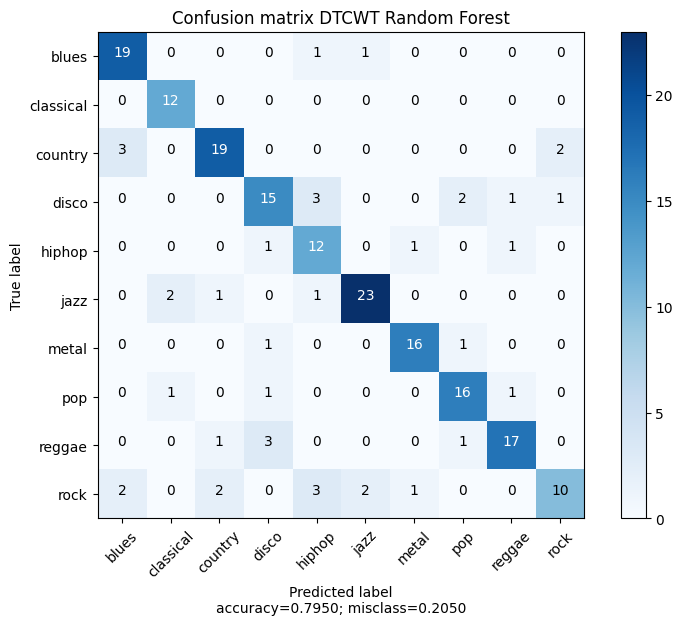

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_dtcwt_test_f, ypred_dtcwt_rf)

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix DTCWT Random Forest')
plt.colorbar()

tick_marks = np.arange(len(GENRES))
plt.xticks(tick_marks, GENRES, rotation=45)
plt.yticks(tick_marks, GENRES)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > (cm.max() / 2) else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('ConfM_DTCWT_rf.png')

A Cross-Validation using K-Fold to validate the accuracy in the previous fit

scores:  [0.755      0.705      0.8        0.82       0.81407035]
mean:  0.7788140703517588


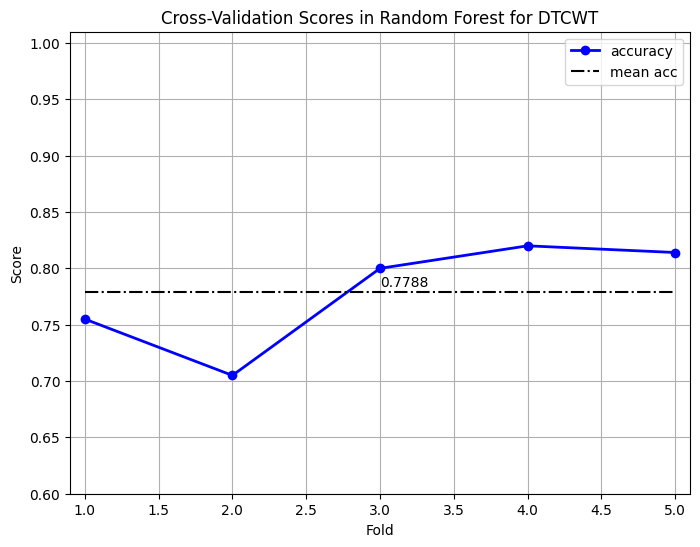

In [135]:
from sklearn.model_selection import KFold, cross_val_score
kfold=KFold(n_splits=5 , shuffle=True,random_state=0) 
rf_scores = cross_val_score(rf_cls,full_x_features, full_y,cv=kfold)

print('scores: ',rf_scores) # [0.755      0.705      0.8        0.82       0.81407035]
print('mean: ',rf_scores.mean()) # 0.7788140703517588

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Cross-Validation Scores in Random Forest for DTCWT')
plt.xlabel('Fold')
plt.ylabel('Score')
ax = plt.gca()
ax.set_xlim(0.9, 5.1)
ax.set_ylim(0.6, 1.01)
plt.grid()
plt.plot(range(1,6),rf_scores,'o-',color='blue',lw=2)
plt.plot(range(1,6),[rf_scores.mean()]*5, linestyle="-.",color='k')
plt.annotate("%0.4f" % rf_scores.mean(), (3,rf_scores.mean() + 0.005))
plt.legend(['accuracy','mean acc'],loc="best")
plt.savefig('CV_DTCWT_rf.png')

Gradient Boosting best found parameters were: `n_estimators=1000`

In [136]:
from sklearn.ensemble import GradientBoostingClassifier

gb_cls = GradientBoostingClassifier(n_estimators=1000,random_state=0)

gb_cls.fit(X_dtcwt_train_f,y_dtcwt_train_f)
# 6 min 15 sec
print(gb_cls.score(X_dtcwt_train_f,y_dtcwt_train_f))
# 1.0
print(gb_cls.score(X_dtcwt_test_f, y_dtcwt_test_f))
# 0.73
ypred_dtcwt_gb = gb_cls.predict(X_dtcwt_test_f)

1.0
0.73


Plot a confusion matrix to corroborate the behavior of the model for each genre

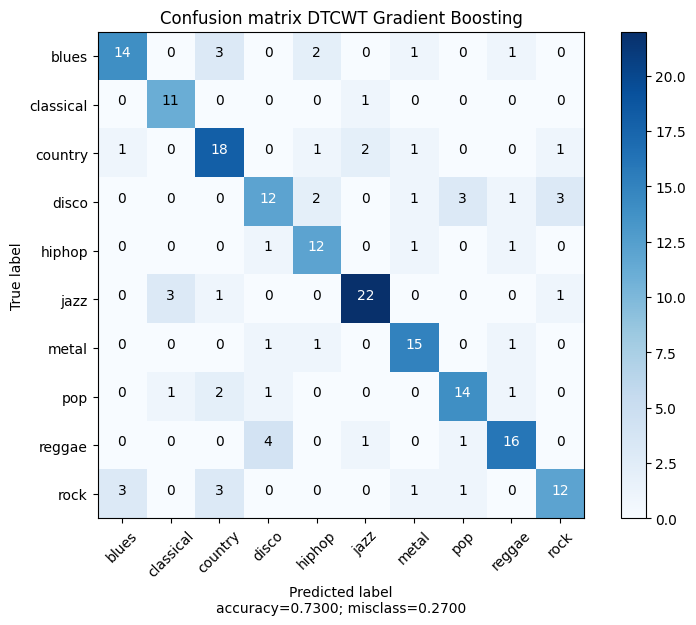

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_dtcwt_test_f, ypred_dtcwt_gb)

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix DTCWT Gradient Boosting')
plt.colorbar()

tick_marks = np.arange(len(GENRES))
plt.xticks(tick_marks, GENRES, rotation=45)
plt.yticks(tick_marks, GENRES)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > (cm.max() / 2) else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('ConfM_DTCWT_gb.png')

A Cross-Validation using K-Fold to validate the accuracy in the previous fit

scores:  [0.715      0.72       0.785      0.79       0.75376884]
mean:  0.7527537688442212


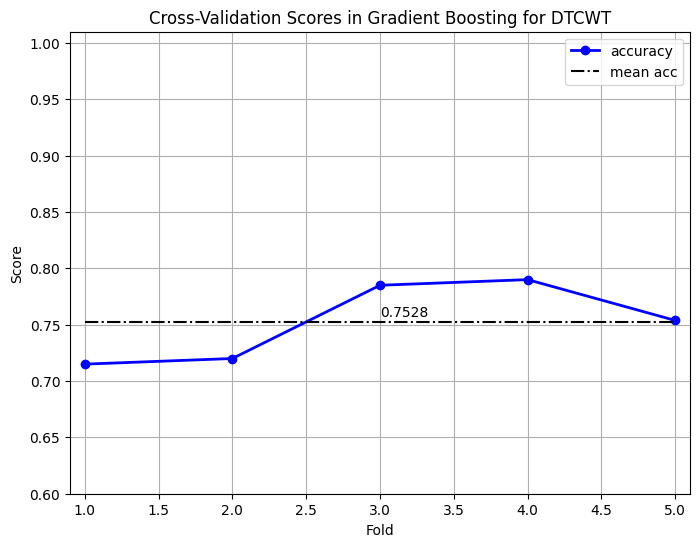

In [139]:
from sklearn.model_selection import KFold, cross_val_score
kfold=KFold(n_splits=5, shuffle=True, random_state=0) 
gb_scores = cross_val_score(gb_cls,full_x_features, full_y,cv=kfold)

print('scores: ',gb_scores) # [0.715      0.71       0.8        0.76       0.76884422]
print('mean: ',gb_scores.mean()) # 0.7507688442211055

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Cross-Validation Scores in Gradient Boosting for DTCWT')
plt.xlabel('Fold')
plt.ylabel('Score')
ax = plt.gca()
ax.set_xlim(0.9, 5.1)
ax.set_ylim(0.6, 1.01)
plt.grid()
plt.plot(range(1,6),gb_scores,'o-',color='blue',lw=2)
plt.plot(range(1,6),[gb_scores.mean()]*5, linestyle="-.",color='k')
plt.annotate("%0.4f" % gb_scores.mean(), (3,gb_scores.mean() + 0.005))
plt.legend(['accuracy','mean acc'],loc="best")
plt.savefig('CV_DTCWT_gb.png')

## Other ML models

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

lr.fit(X_dwt_train,y_dwt_train)
# 0.4 sec
lr.score(X_dwt_train, y_dwt_train)
# 0.95
lr.score(X_dwt_test, y_dwt_test)
# 0.644
ypred_dwt = lr.predict(X_dwt_test)
print(np.mean(ypred_dwt==y_dwt_test))

0.644


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.svm import SVC, LinearSVC
lsvc = LinearSVC(random_state=0)

lsvc.fit(X_dwt_train,y_dwt_train)
# 0.7 sec
lsvc.score(X_dwt_train, y_dwt_train)
# 0.96
lsvc.score(X_dwt_test, y_dwt_test)
# 0.676
ypred_dwt = lsvc.predict(X_dwt_test)
print(np.mean(ypred_dwt==y_dwt_test))

In [ ]:
svc = SVC(random_state=0)

svc.fit(X_dwt_train,y_dwt_train)
# 0.2 sec
svc.score(X_dwt_train, y_dwt_train)
# 0.85 
svc.score(X_dwt_test, y_dwt_test)
# 0.616
ypred_dwt = svc.predict(X_dwt_test)
print(np.mean(ypred_dwt==y_dwt_test))

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

lr.fit(X_dtcwt_train,y_dtcwt_train)
# 0.2 sec
lr.score(X_dtcwt_train, y_dtcwt_train)
# 0.95
lr.score(X_dtcwt_test, y_dtcwt_test)
# 0.716

In [ ]:
from sklearn.svm import SVC, LinearSVC
lsvc = LinearSVC(random_state=0,max_iter=10000)

lsvc.fit(X_dtcwt_train,y_dtcwt_train)
# 3.4 sec
lsvc.score(X_dtcwt_train, y_dtcwt_train)
# 0.96
lsvc.score(X_dtcwt_test, y_dtcwt_test)
# 0.692

In [ ]:
svc = SVC(random_state=0)

svc.fit(X_dtcwt_train,y_dtcwt_train)
# 0.2 sec
svc.score(X_dtcwt_train, y_dtcwt_train)
# 0.81
svc.score(X_dtcwt_test, y_dtcwt_test)
# 0.68

## Random Forest Classifier Hyperparameters tuning

In [ ]:
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

rfbase = RandomForestClassifier(n_estimators=100,max_depth=13,bootstrap=False,random_state=0) # n_jobs = 3, max_features = 'auto', bootstrap=False

param_grid = {
    'n_estimators': range(200, 600, 100), 
    # 'max_features': [0.05,0.07,0.09,0.1],
    # 'bootstrap': [False, True],
    # 'max_depth':range(100, 1000, 100)
}

def roc_auc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:])

scorer = make_scorer(accuracy_score)

rf_fit = GridSearchCV(estimator=rfbase, param_grid=param_grid,
                 scoring = scorer, return_train_score=True)

In [ ]:
rf_fit.fit(X_dtcwt_train, y_dtcwt_train)
results = rf_fit.cv_results_
results

{'mean_fit_time': array([1.71187282, 2.45271282, 3.2414113 , 4.10359077]),
 'std_fit_time': array([0.13183606, 0.01523087, 0.03420315, 0.07271847]),
 'mean_score_time': array([0.02679019, 0.03978734, 0.05264626, 0.06537433]),
 'std_score_time': array([0.00160372, 0.00131738, 0.00169044, 0.002081  ]),
 'param_n_estimators': masked_array(data=[200, 300, 400, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 200},
  {'n_estimators': 300},
  {'n_estimators': 400},
  {'n_estimators': 500}],
 'split0_test_score': array([0.64666667, 0.64      , 0.64666667, 0.64666667]),
 'split1_test_score': array([0.75333333, 0.74666667, 0.75333333, 0.74666667]),
 'split2_test_score': array([0.72666667, 0.72      , 0.72666667, 0.72666667]),
 'split3_test_score': array([0.79333333, 0.79333333, 0.78666667, 0.77333333]),
 'split4_test_score': array([0.75167785, 0.74496644, 0.75838926, 0.75167785]),
 'mean_test_score': array([0

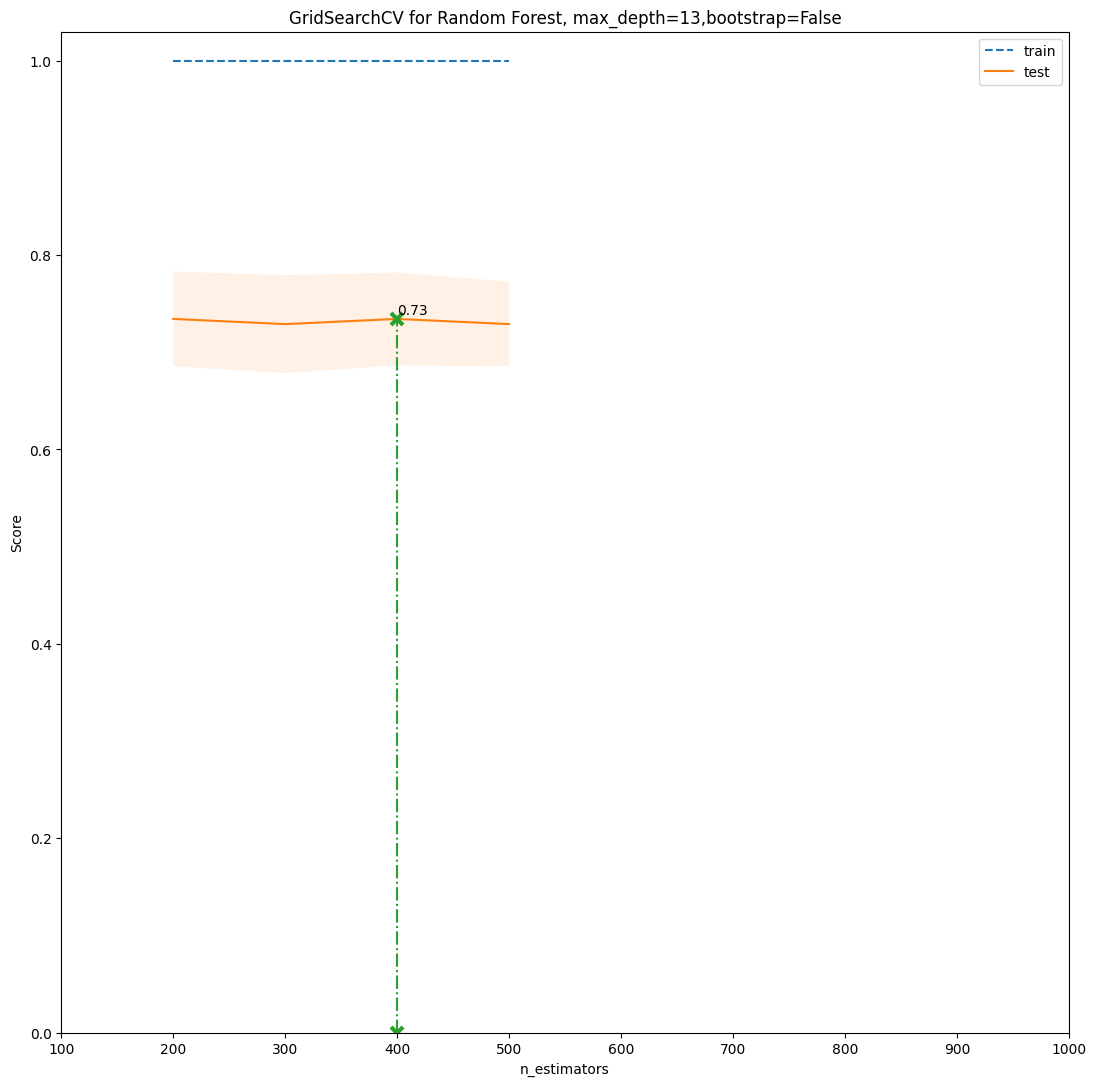

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV for Random Forest, max_depth=13,bootstrap=False", fontsize=12)

plt.xlabel("n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(100, 1000)
ax.set_ylim(0, 1.03)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_estimators"].data, dtype=float)


for sample, style in (("train", "--"), ("test", "-")):
    sample_score_mean = results['mean_%s_score' % sample]
    sample_score_std = results['std_%s_score' % sample]
    ax.fill_between(
        X_axis,
        sample_score_mean - sample_score_std,
        sample_score_mean + sample_score_std,
        alpha=0.1 if sample == "test" else 0
        # color=color,
    )
    ax.plot(
        X_axis,
        sample_score_mean,
        style,
        # color=color,
        # alpha=1 if sample == "test" else 0.7,
        label="%s" % sample,
    )

best_index = np.nonzero(results["rank_test_score"] == 1)[0][0]
best_score = results['mean_test_score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot(
    [
        X_axis[best_index],
    ]
    * 2,
    [0, best_score],
    linestyle="-.",
    # color=color,
    marker="x",
    markeredgewidth=3,
    ms=8,
)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()